[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1oG0Q__VzHYfgV_vZyVf4XbhFmlhYO5Bf)


In [ ]:
import wget

url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/tywbtsjrjv-1.zip"
wget.download(url, "dataset.zip")

In [ ]:
!unzip /content/dataset.zip

!unzip '/content/Data for Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network/Plant_leaf_diseases_dataset_with_augmentation.zip'

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


In [ ]:
# Install and import split-folders
!pip install split-folders

import splitfolders


In [ ]:
# Split dataset into train/val/test
splitfolders.ratio(
    '/content/Plant_leave_diseases_dataset_with_augmentation',
    output="plant data",
    seed=1337,
    ratio=(.8, .1, .1)
)

Copying files: 61486 files [00:14, 4359.91 files/s]


**Data Preprocessing**

In [ ]:
train_dir = '/content/plant data/train'
validation_dir = '/content/plant data/val'
test_dir = '/content/plant data/test'
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
# Create datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 49179 files belonging to 39 classes.
Found 9215 files belonging to 39 classes.
Found 6170 files belonging to 39 classes.


In [ ]:
class_names = train_dataset.class_names
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")


Number of classes: 39
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'T

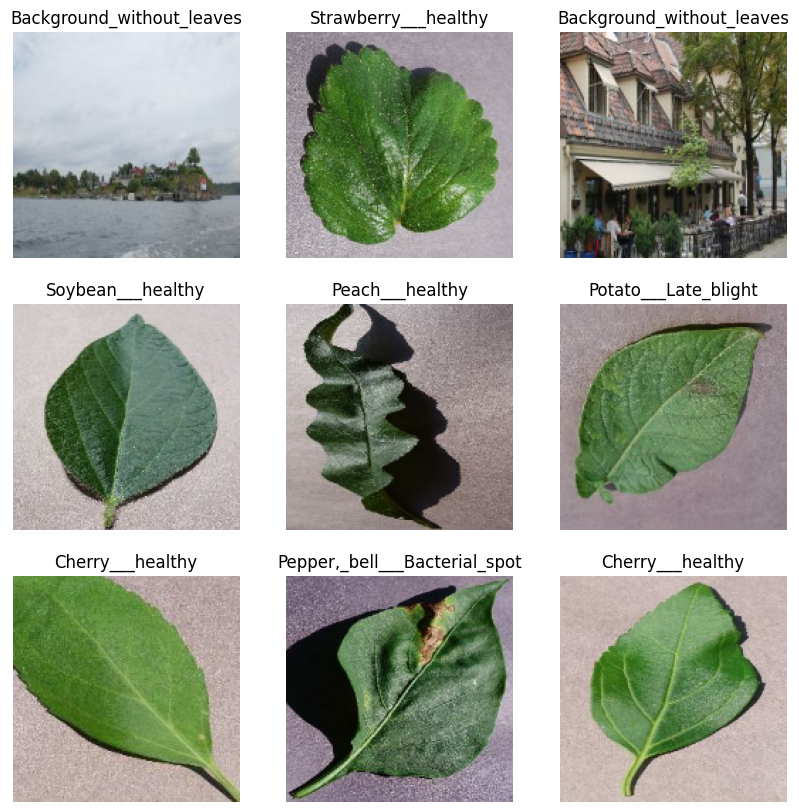

In [ ]:
# Visualize sample images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [ ]:
# Optimize performance with prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


**Create the base model from pre-trained MobileNetV3**

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)


/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Freeze the base model
base_model.trainable = False

base_model.summary()



Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 160, 160,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 80, 80,    │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 80, 80,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 80,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 80, 80,    │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 80, 80,    │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 80, 80,    │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 80, 80,    │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 81, 81,    │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 40, 40,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 40, 40,    │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:
# Build the complete model
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

inputs = tf.keras.Input(shape=IMG_SHAPE)

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)       # Increased dropout
outputs = tf.keras.layers.Dense(
    len(class_names),
    activation='softmax',
    kernel_regularizer=tf.keras.regularizers.l2(1e-4)   # L2 regularization
)(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 5, 5, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 39)             │        37,479 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,033,831 (11.57 MB)

 Trainable params: 37,479 (146.40 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)


**Initial Training (with frozen base model)**

In [ ]:
initial_epochs = 10

# Add callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True,
        monitor='val_sparse_categorical_accuracy'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=2,
        monitor='val_loss'
    )
]

history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/10
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 77s 43ms/step - loss: 1.4017 - sparse_categorical_accuracy: 0.6348 - val_loss: 0.2813 - val_sparse_categorical_accuracy: 0.9297 - learning_rate: 0.0010
Epoch 2/10
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 75s 42ms/step - loss: 0.4011 - sparse_categorical_accuracy: 0.8873 - val_loss: 0.2396 - val_sparse_categorical_accuracy: 0.9353 - learning_rate: 0.0010
Epoch 3/10
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 63s 41ms/step - loss: 0.3506 - sparse_categorical_accuracy: 0.9011 - val_loss: 0.2190 - val_sparse_categorical_accuracy: 0.9440 - learning_rate: 0.0010
Epoch 4/10
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - loss: 0.3395 - sparse_categorical_accuracy: 0.9076 - val_loss: 0.2115 - val_sparse_categorical_accuracy: 0.9478 - learning_rate: 0.0010
Epoch 5/10
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - loss: 0.3285 - sparse_categorical_accuracy: 0.9094 - val_loss: 0.2110 - val_sparse_categorical_accuracy: 0.9506 - learning_rate: 0.0010
Epoch 6/10
1537/1537 ━━━━━━━━━

**Fine Tuning**


In [ ]:
# Unfreeze the base model
base_model.trainable = True

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers) - 30

# Freeze all layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [ ]:
# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)


In [ ]:
# Continue training
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=initial_epochs,  # Fixed: was history.epoch[-1]
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 11/20
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 104s 60ms/step - loss: 3.2173 - sparse_categorical_accuracy: 0.4471 - val_loss: 0.5170 - val_sparse_categorical_accuracy: 0.8661 - learning_rate: 1.0000e-06
Epoch 12/20
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 139s 59ms/step - loss: 1.9534 - sparse_categorical_accuracy: 0.5805 - val_loss: 0.6897 - val_sparse_categorical_accuracy: 0.8201 - learning_rate: 1.0000e-06
Epoch 13/20
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 144s 60ms/step - loss: 1.2977 - sparse_categorical_accuracy: 0.6815 - val_loss: 0.5455 - val_sparse_categorical_accuracy: 0.8539 - learning_rate: 1.0000e-06
Epoch 14/20
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 139s 59ms/step - loss: 0.9978 - sparse_categorical_accuracy: 0.7391 - val_loss: 0.4581 - val_sparse_categorical_accuracy: 0.8795 - learning_rate: 5.0000e-07
Epoch 15/20
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 90s 59ms/step - loss: 0.8693 - sparse_categorical_accuracy: 0.7685 - val_loss: 0.3977 - val_sparse_categorical_accuracy: 0.8964 - learning_rate: 5.0000e-07
E

**Visualize Training Results**


In [ ]:
# Combine training histories
acc = history.history['sparse_categorical_accuracy'] + \
      history_fine.history['sparse_categorical_accuracy']

val_acc = history.history['val_sparse_categorical_accuracy'] + \
          history_fine.history['val_sparse_categorical_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']


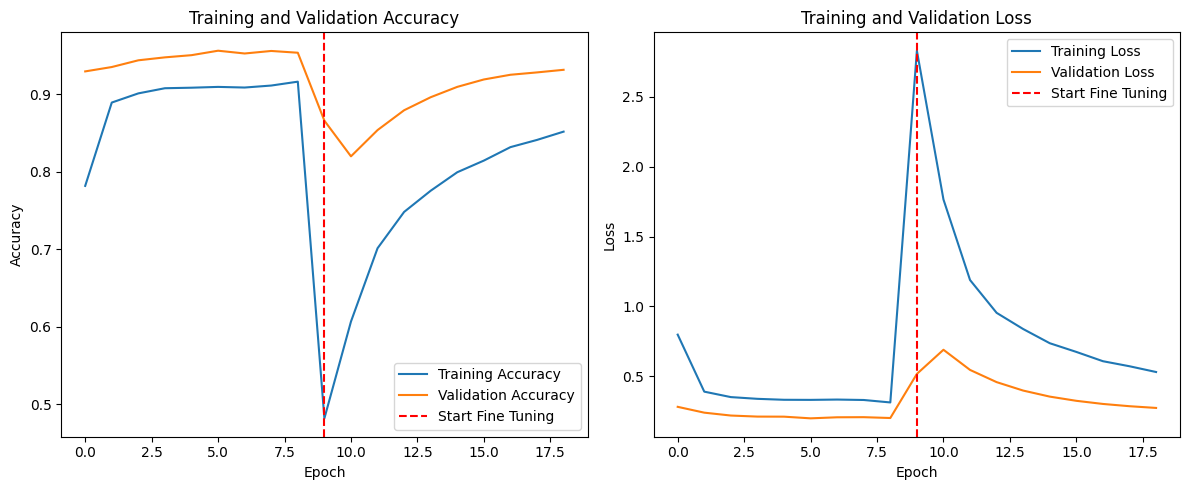

In [ ]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=initial_epochs-1, color='r', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=initial_epochs-1, color='r', linestyle='--', label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


**Evaluate on Test Set**


In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.2817 - sparse_categorical_accuracy: 0.9280

Test Loss: 0.2815
Test Accuracy: 0.9295


**Make Predictions on Test Set**


In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions, axis=1)

print('\nPredictions:\n', predictions.numpy())
print('Labels:\n', label_batch)



Predictions:
 [25 33 16 27 31 17 13 17  9 27 31 36  3  8 26 16 14 17 25 38  5 26 34 16
 29 25  6 27 21 38 33  3]
Labels:
 [25 35 16 27 31 17 13 17  9 27 31 36  3  8 26 16 14 17 25 38  5 26 35 16
 29 25  6 27 21 38 33  3]


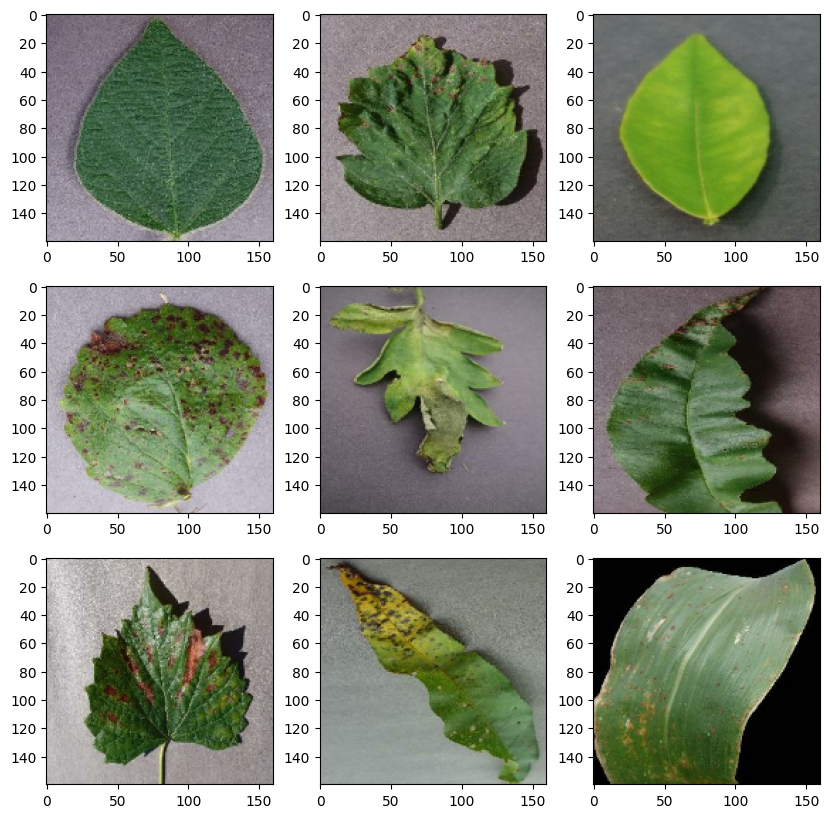

In [ ]:
# Visualize predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))


In [ ]:
    # Show prediction and actual label
    pred_label = class_names[int(predictions[i])]
    true_label = class_names[label_batch[i]]


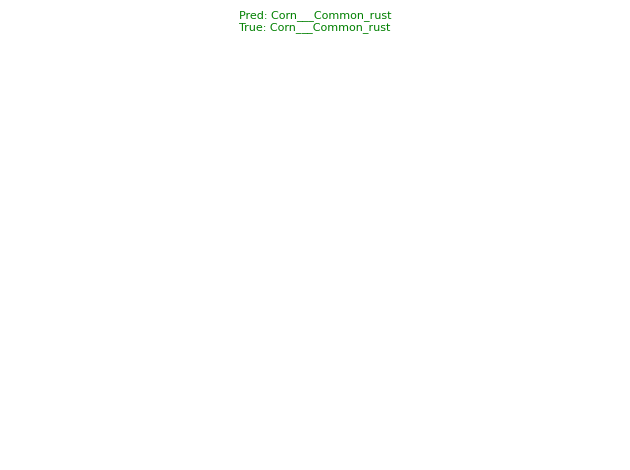

In [ ]:
    # Color code: green if correct, red if incorrect
    color = "green" if predictions[i] == label_batch[i] else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━

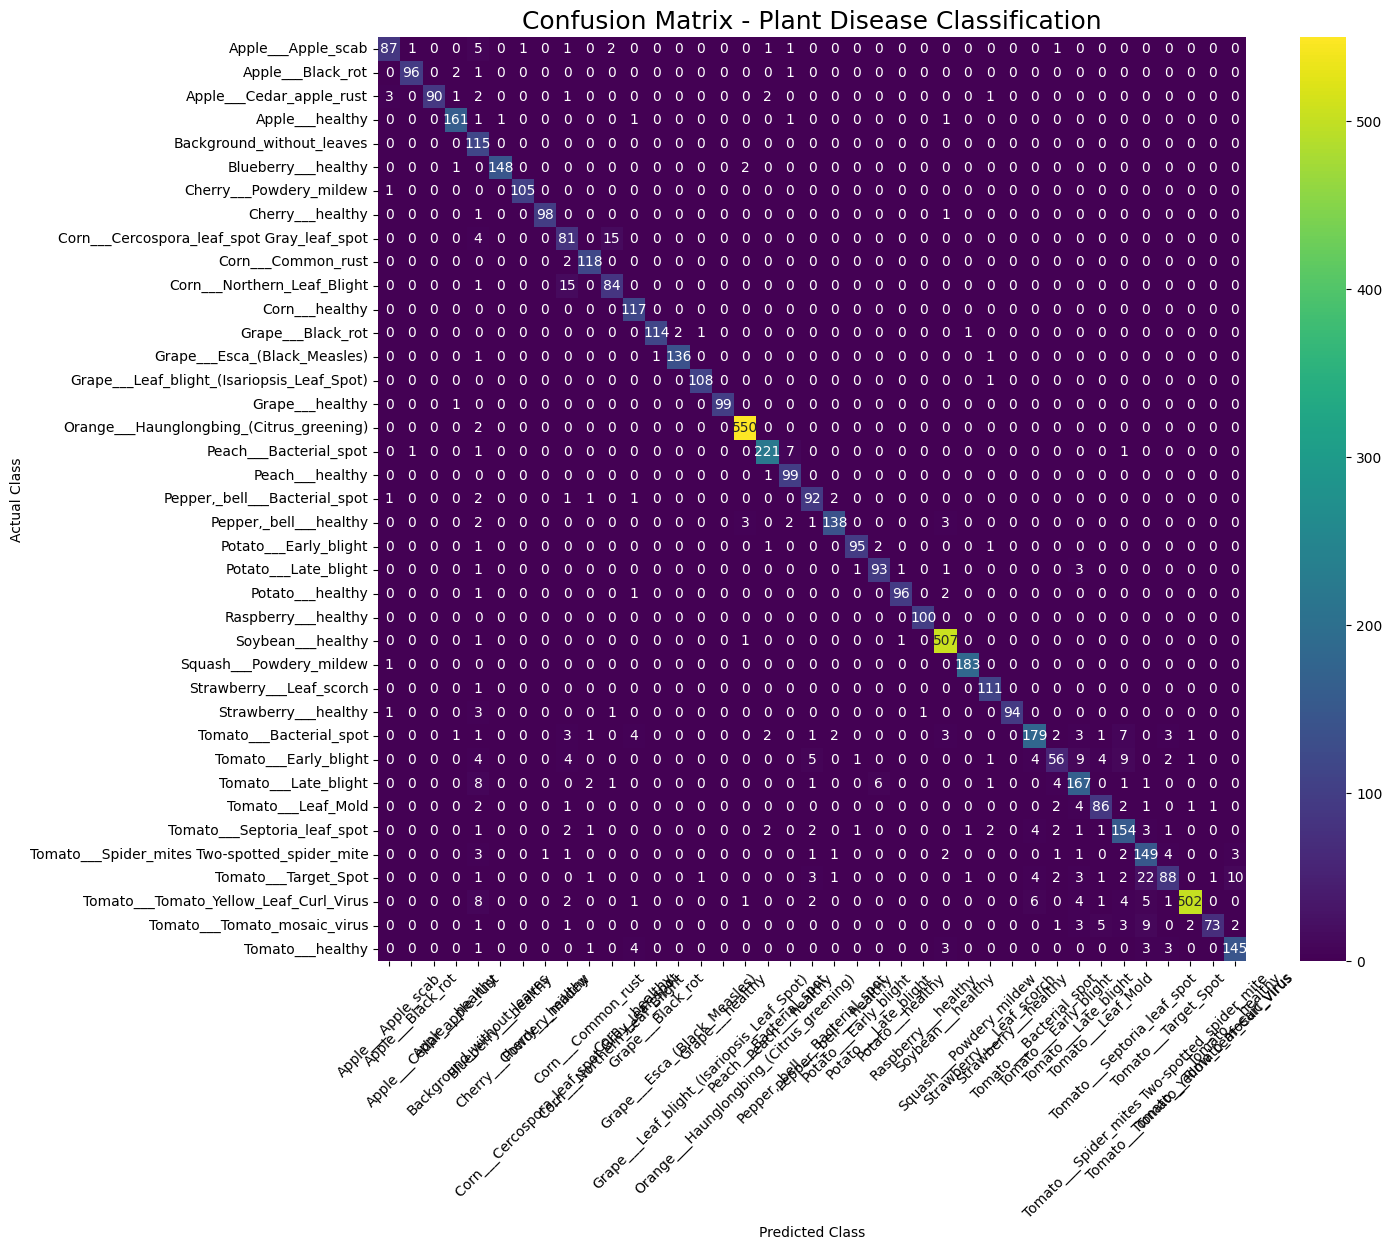

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix - Plant Disease Classification", fontsize=18)
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


**Save Model**


In [ ]:
model.export("saved_model")
print("\nModel saved successfully!")

# Verify loading
try:
    loaded_model = tf.saved_model.load("saved_model")
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_203')
Output Type:
  TensorSpec(shape=(None, 39), dtype=tf.float32, name=None)
Captures:
  134951169131344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134951162519888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134951162521808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134951162524304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134951162524688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134951162524496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134951169143632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134951162525264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134951162525072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134951162526800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13495116252660


Generating predictions for confusion matrix...


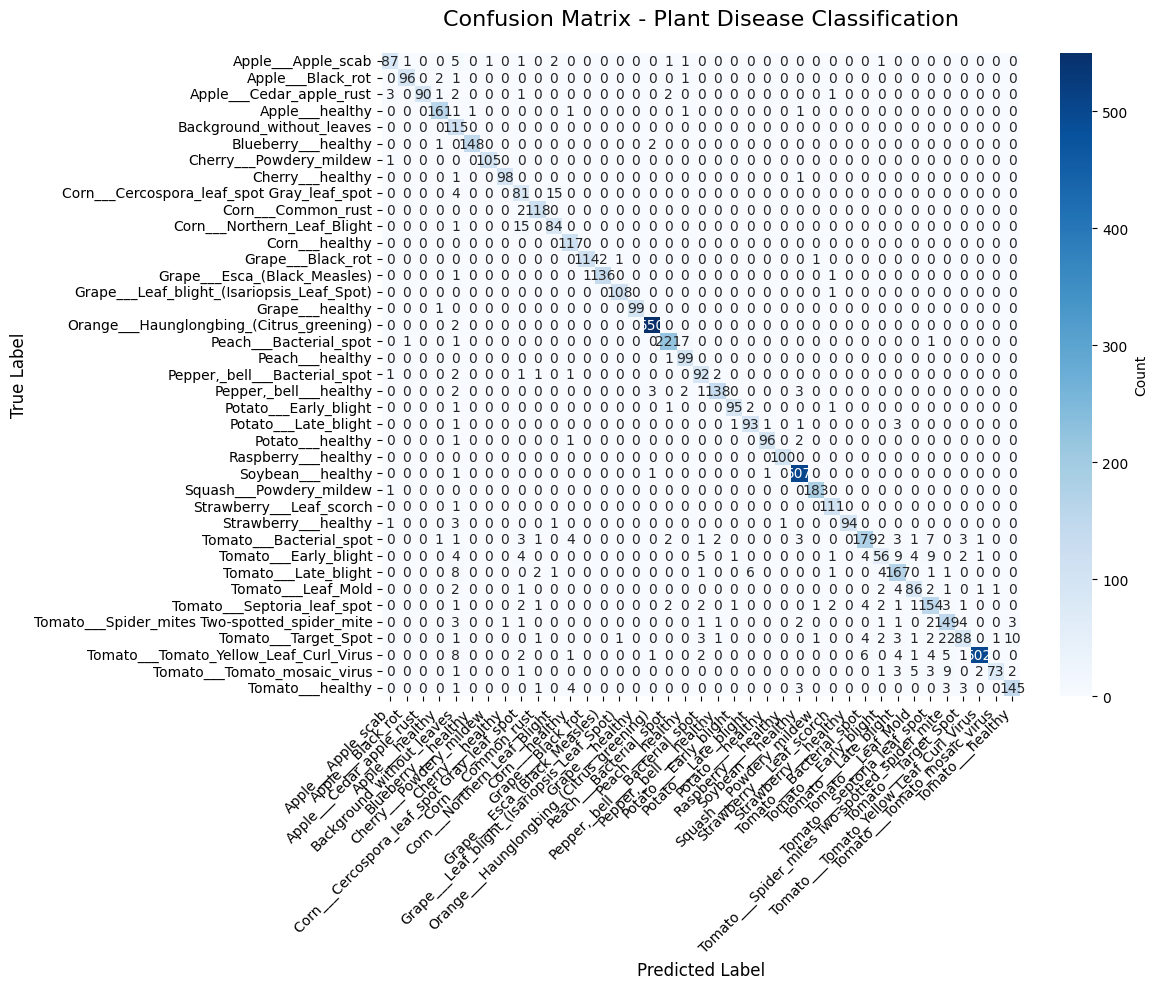

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get all predictions and true labels
y_true = []
y_pred = []

print("\nGenerating predictions for confusion matrix...")
for images, labels in test_dataset:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Plant Disease Classification', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [ ]:
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred, target_names=class_names))



CLASSIFICATION REPORT
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.93      0.87      0.90       100
                            Apple___Black_rot       0.98      0.96      0.97       100
                     Apple___Cedar_apple_rust       1.00      0.90      0.95       100
                              Apple___healthy       0.96      0.97      0.97       166
                    Background_without_leaves       0.65      1.00      0.79       115
                          Blueberry___healthy       0.99      0.98      0.99       151
                      Cherry___Powdery_mildew       0.99      0.99      0.99       106
                             Cherry___healthy       0.99      0.98      0.98       100
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.70      0.81      0.75       100
                           Corn___Common_rust       0.94      0.98      0.96       120
                  C

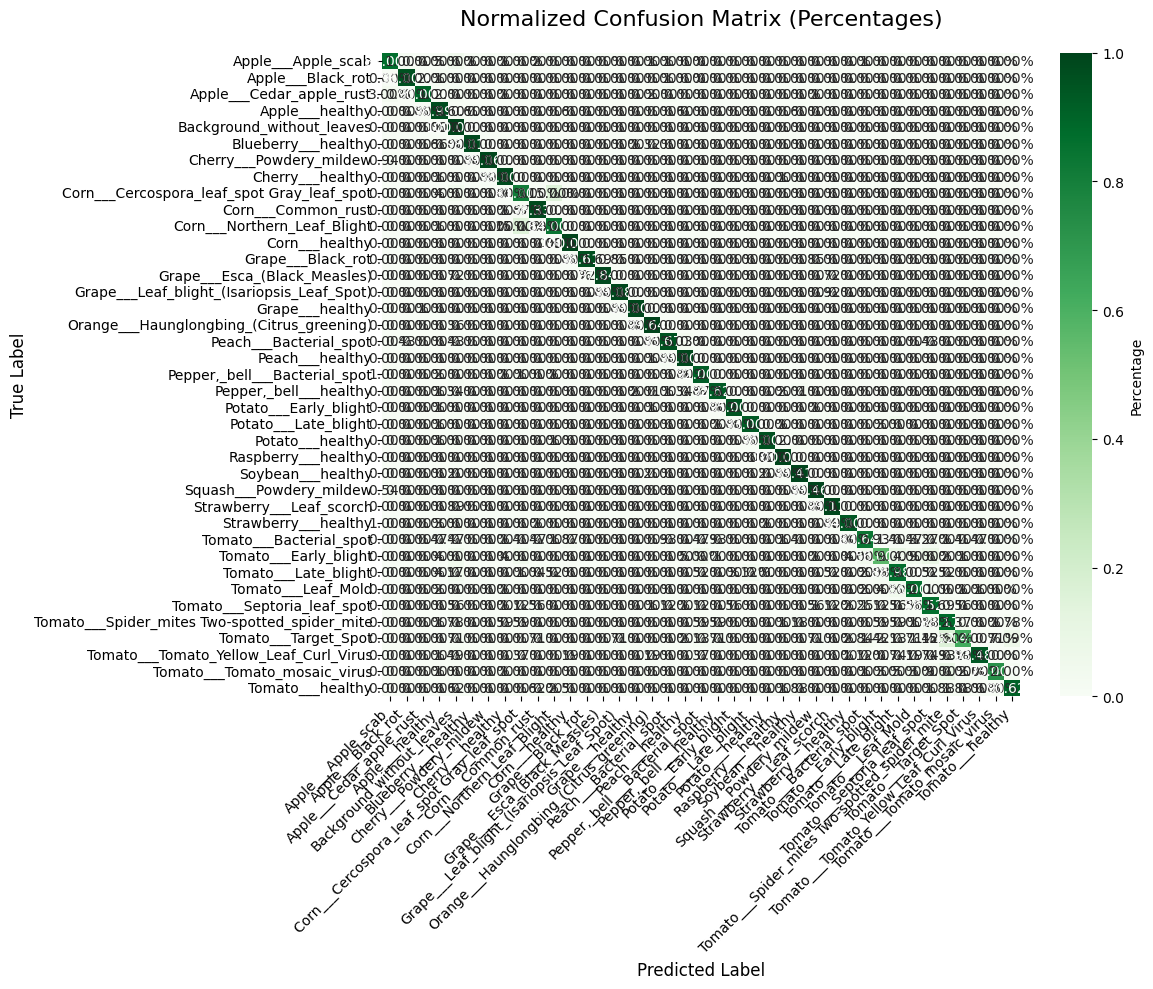

In [ ]:
# Normalized confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix (Percentages)', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [ ]:
print("\n" + "="*70)
print("PER-CLASS ACCURACY")
print("="*70)
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, class_name in enumerate(class_names):
    print(f"{class_name:30s}: {class_accuracy[i]*100:.2f}%")



PER-CLASS ACCURACY
Apple___Apple_scab            : 87.00%
Apple___Black_rot             : 96.00%
Apple___Cedar_apple_rust      : 90.00%
Apple___healthy               : 96.99%
Background_without_leaves     : 100.00%
Blueberry___healthy           : 98.01%
Cherry___Powdery_mildew       : 99.06%
Cherry___healthy              : 98.00%
Corn___Cercospora_leaf_spot Gray_leaf_spot: 81.00%
Corn___Common_rust            : 98.33%
Corn___Northern_Leaf_Blight   : 84.00%
Corn___healthy                : 100.00%
Grape___Black_rot             : 96.61%
Grape___Esca_(Black_Measles)  : 97.84%
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 99.08%
Grape___healthy               : 99.00%
Orange___Haunglongbing_(Citrus_greening): 99.64%
Peach___Bacterial_spot        : 95.67%
Peach___healthy               : 99.00%
Pepper,_bell___Bacterial_spot : 92.00%
Pepper,_bell___healthy        : 92.62%
Potato___Early_blight         : 95.00%
Potato___Late_blight          : 93.00%
Potato___healthy              : 96.00%
Raspberr

**Quantization (TFLite Conversion)**


In [ ]:
try:
    converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Allow select TensorFlow operations (Flex ops) to be included in the TFLite model
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]

    tflite_model = converter.convert()
        # Save the quantized model
    with open("model_int8.tflite", "wb") as f:
        f.write(tflite_model)

    print(f"\nQuantized model saved! Size: {len(tflite_model) / (1024*1024):.2f} MB")

except Exception as e:
    print(f"Error during quantization: {e}")

print("\n✅ Training and model export completed successfully!")


Quantized model saved! Size: 3.18 MB

✅ Training and model export completed successfully!
